# Object detection

After importing and manipulating images, the detection of objects in these images is a common next step. We will introduce histogram of oriented gradients filter and analytical methods.

In [1]:
# Import OpenCV
import cv2
# Since OpenCV is based on numpy:
import numpy as np
# Import pyplot (we will need this to plot with the notebook)
import matplotlib.pyplot as plt
# Helper function to provide plots in true colors in the notebook
def imshow(title, im):
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.title(title)

## Analytical methods

We will try to detect the location and size of a red Sh2-signal, as depicted below:

![Muttental](figures/Muttentalbahn.jpg)

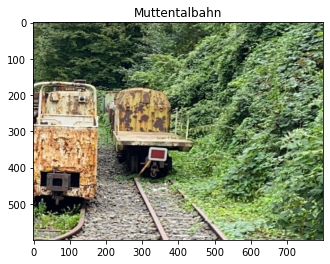

In [2]:
# Load and inspect image
im = cv2.imread('figures/Muttentalbahn.jpg')
imshow('Muttentalbahn', im)

We will try to find it due to its strong red colour, let's inspect the three colour channels:

Text(0.5, 1.0, 'Red')

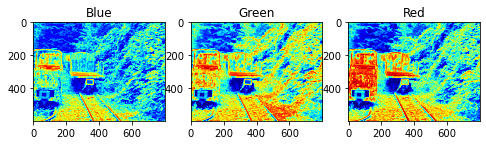

In [3]:
plt.figure(figsize = (8,12))
plt.subplot(131)
plt.imshow(im[:,:,0], cmap = 'jet')
plt.title('Blue')
plt.subplot(132)
plt.imshow(im[:,:,1], cmap = 'jet')
plt.title('Green')
plt.subplot(133)
plt.imshow(im[:,:,2], cmap = 'jet')
plt.title('Red')

Apparently, the red isn't as strong as hoped for, especially the brown rust makes it difficult. However, we can remove parts of the brown by observing that green and red channels look almost the same for the rusty patches, so **Red - Green** may be helpful:

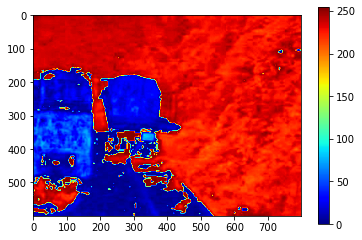

In [4]:
plt.imshow(im[:,:,2] - im[:,:,1], cmap = 'jet')
plt.colorbar()

Indeed, the signal values appear to be between 60 and 90 in the subtracted image. 

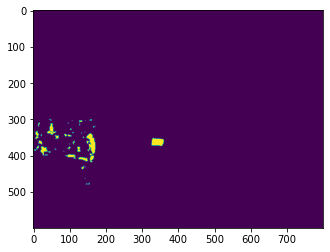

In [5]:
imRdGn = im[:,:,2] - im[:,:,1]
imFilt = 255.0*(imRdGn > 60)*(imRdGn<90)
ret,imBW = cv2.threshold(imFilt,250,255,cv2.THRESH_BINARY)
plt.imshow(imBW)


The signal is visible, however also plenty of rust on the left side. Morphological operations can be used to remove these:

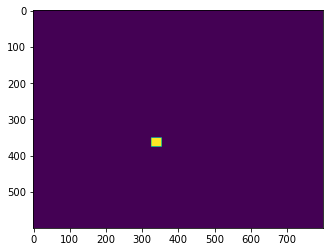

In [6]:
# Define Kernel
kernel = np.ones((7,7),np.uint8)
# Twice erosion
imBW = cv2.erode(imBW,kernel,iterations = 3)
# Twice dilation to restore original size
imBW = cv2.dilate(imBW,kernel,iterations = 4)
# Plot
plt.imshow(imBW)

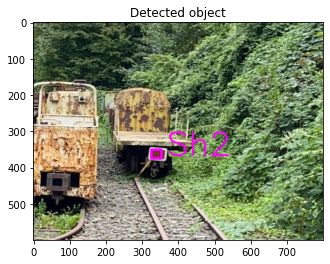

In [7]:
imBW = np.uint8(imBW)
#edges = cv2.Canny(imBW, 100,200)
contours, hierarchy= cv2.findContours(imBW, 
                                      cv2.RETR_LIST, 
                                      cv2.CHAIN_APPROX_NONE)
for c in contours:
    accuracy= 0.03 * cv2.arcLength(c, True)
    approx= cv2.approxPolyDP(c,accuracy,True)
    cv2.drawContours(im, [approx], 0, (255,0,255),5)
    cv2.putText(im, 'Sh2', 
                (c[:,0][:,0].max()+15, c[:,0][:,1].min()+15), 
                cv2.FONT_HERSHEY_SIMPLEX,  
                   3, (255,0,255), 4, cv2.LINE_AA)

imshow('Detected object',im)

## Exercise

Try to detect the locomotive to the left in a similar fashion, effectively building a computer vision pipeline.

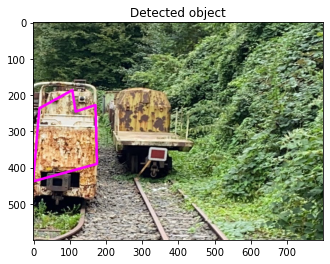

In [8]:
# Load and inspect image
im = cv2.imread('figures/Muttentalbahn.jpg')
imRed = im[:,:,2]
# Smoothing to remove ballast
imRed = cv2.GaussianBlur(imRed,(35,35), 13)
# Thresholdung
ret,imLoco = cv2.threshold(imRed,205,255,cv2.THRESH_BINARY)
# Convert to black and white
imBW = np.uint8(imLoco)
# Define Kernel
kernel = np.ones((15,15),np.uint8)
# Twice dilation to close contour gaps
imBW = cv2.dilate(imBW,kernel,iterations =2)

contours, hierarchy= cv2.findContours(imBW, 
                                      cv2.RETR_LIST, 
                                      cv2.CHAIN_APPROX_NONE)
for c in contours:
    accuracy= 0.03 * cv2.arcLength(c, True)
    approx= cv2.approxPolyDP(c,accuracy,True)
    # Only "rich" contours which are more than a quadrangle:
    if len(approx) > 4:
        cv2.drawContours(im, [approx], 0, (255,0,255),5)


imshow('Detected object',im)

## Face detection

After the analytical approach, which has certain drawbacks e.g. under changing lighting conditions, we will find faces in an image using a histogram of oriented gradients (HOG) approach. This is a quite efficient way and is the typical implementation in e.g. smartphone cameras.

To load the classifier, which is shipped with OpenCV, it is necessary to provide the full path to the ```load```method.

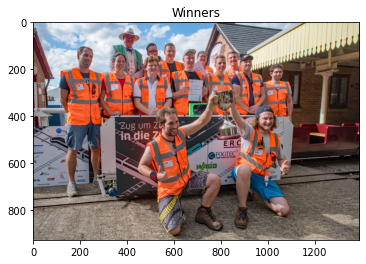

In [9]:
im = cv2.imread('figures/Winners2019.jpg')
h,w,c = im.shape
im = cv2.resize(im, (int(0.25*w), int(0.25*h)))
face_cascade = cv2.CascadeClassifier()
face_cascade.load('/Users/raphael/opt/anaconda3/envs/opencvjupyter/share/opencv4/haarcascades/haarcascade_frontalface_alt.xml')

imshow('Winners', im)

In [10]:
imGray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
imGray = cv2.equalizeHist(imGray)

faces = face_cascade.detectMultiScale(imGray, 1.05, 10)

In [11]:
imFaces = im.copy()
for (x,y,w,h) in faces:
        imFaces = cv2.rectangle(im, (x, y), (x+w,y+h), (255, 0, 255), 5)

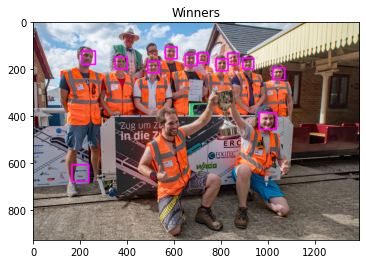

In [12]:
imshow('Winners', imFaces)

This results shows that with object detection, we will mostly obtain false positive (lower left) as well as false negative (front and back).

Advantages are the higher robustness against changing environments and the comparably little required data for custom training.

## Exercise

The ```detectMultiScale``` method accepts several optional parameters, most notably the detection threshold and the windowStride, currently 1.05 and 10, resepectively. Experiment with these parameters. Can you detect the two missing persons? What happens to your overall detection?

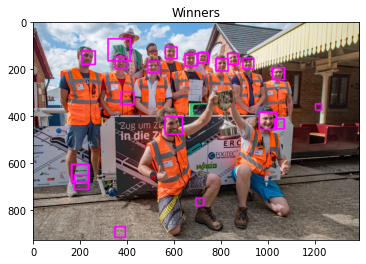

In [13]:
faces = face_cascade.detectMultiScale(imGray, 1.02, 2)
imFaces = im.copy()
for (x,y,w,h) in faces:
        imFaces = cv2.rectangle(im, (x, y), (x+w,y+h), (255, 0, 255), 5)
imshow('Winners', imFaces)

## Exercise

Use the ```haarcascade_fullbody.xm``` classifier to detect people in 'figures/Korea2.jpg'.

![People](figures/Korea2.JPG)

How many can you detect?

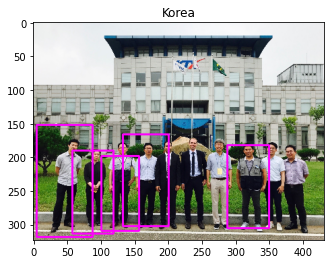

In [14]:
im = cv2.imread('figures/Korea2.jpg')
h,w,c = im.shape
im = cv2.resize(im, (int(0.25*w), int(0.25*h)))
body_cascade = cv2.CascadeClassifier()
body_cascade.load('/Users/raphael/opt/anaconda3/envs/opencvjupyter/share/opencv4/haarcascades/haarcascade_fullbody.xml')
imGray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
imGray = cv2.equalizeHist(imGray)

bodies = body_cascade.detectMultiScale(imGray, 1.01, 10)
imFaces = im.copy()
for (x,y,w,h) in bodies:
        imBodies = cv2.rectangle(im, (x, y), (x+w,y+h), (255, 0, 255), 2)

imshow('Korea', imBodies)